# Shallow Water Equations

In [318]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import animation
from IPython.display import HTML

## Newtonian, 2d, single layer

In [323]:
# define grids
nx = 2000
nt = 2000
xmin = 0.
xmax = 10.

x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
hu = np.zeros((nx, nt+1))
h = np.zeros((nx, nt+1))
# Start off with an initial water hill
h[1:-1,0] = 1 + 0.4 * np.exp(-(x-5)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
h[0,0] = h[-2,0]
h[-1,0] = h[1,0]

#hu[:,0] = 0.1 * h[:,0]

dx = x[1] - x[0]
dt = 0.5 * dx

# set gravity
g = 1.0

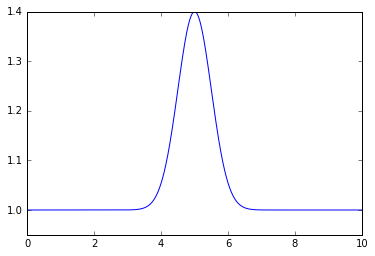

In [274]:
plt.plot(x,h[1:-1,0])
plt.show()

In [291]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    # Jacobean
    J = np.zeros((nx-2, 2, 2))
    J[:,0,1] = 1.
    J[:,1,0] = -(hu[1:-1,n]/h[1:-1,n])**2 + g * h[1:-1,n]
    J[:,1,1] =  2 * hu[1:-1,n] / h[1:-1,n]
    
    J2 = np.array([np.dot(J[i,:,:], J[i,:,:]) for i in range(nx-2)])
    
    h[1:-1,n+1] = h[1:-1,n] - 0.5 * dt/dx * (J[:,0,0] * (h[2:,n] - h[:-2,n]) + J[:,0,1] * (hu[2:,n] - hu[:-2,n])) +\
                  0.5 * (dt/dx)**2 * (J2[:,0,0] * (h[:-2,n] - 2 * h[1:-1,n] + h[2:,n]) + \
                                      J2[:,0,1] * (hu[:-2,n] - 2 * hu[1:-1,n] + hu[2:,n]))
    hu[1:-1,n+1] = hu[1:-1,n] - 0.5 * dt/dx * (J[:,1,0] * (h[2:,n] - h[:-2,n]) + J[:,1,1] * (hu[2:,n] - hu[:-2,n]))+ \
                  0.5 * (dt/dx)**2 * (J2[:,1,0] * (h[:-2,n] - 2 * h[1:-1,n] + h[2:,n]) + \
                                      J2[:,1,1] * (hu[:-2,n] - 2 * hu[1:-1,n] + hu[2:,n]))

    # do boundaries - periodic
    h[0,n+1] = h[-2,n+1]
    h[-1,n+1] = h[1,n+1]
    hu[0,n+1] = hu[-2,n+1]
    hu[-1,n+1] = hu[1,n+1]

In [324]:
for i in range(nt):
    evolve(i)

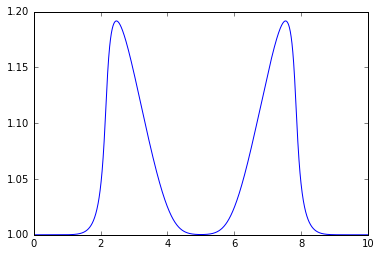

In [325]:
plt.plot(x,h[1:-1,800])
plt.show()

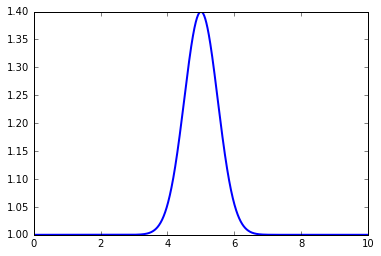

In [333]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(1.,1.4))
line = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(x, h[1:-1,i*10])
    #return line

anim = animation.FuncAnimation(fig, animate, frames=130, interval=25)#, blit=True)

In [334]:
HTML(anim.to_html5_video())

## Newtonian, 2d, multilayer

In [410]:
# define grids
nx = 2000
nt = 2000
nlayers = 2
xmin = 0.
xmax = 10.

x = np.linspace(xmin, xmax, num=nx-2, endpoint=False)
hu = np.zeros((nlayers, nx, nt+1))
h = np.zeros((nlayers, nx, nt+1))
# Start off with an initial water hill
h[0,1:-1,0] = 1 + 0.4 * np.exp(-(x-5)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
h[1,1:-1,0] = 0.8 + 0.1 * np.exp(-(x-5)**2*2)
h[:,0,0] = h[:,-2,0]
h[:,-1,0] = h[:,1,0]

#hu[:,0] = 0.1 * h[:,0]

dx = x[1] - x[0]
dt = 0.5 * dx

# set gravity
g = 1.0

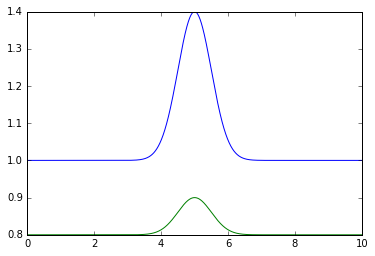

In [361]:
plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0])
plt.show()

In [406]:
# evolution using second-order Lax-Wendroff
def evolve(n):
    
    for j in range(nlayers):

        # Jacobean
        J = np.zeros((nx-2, 2, 2))
        J[:,0,1] = 1.
        J[:,1,0] = -(hu[j,1:-1,n]/h[j,1:-1,n])**2 + g * h[j,1:-1,n]
        J[:,1,1] =  2 * hu[j,1:-1,n] / h[j,1:-1,n]

        J2 = np.array([np.dot(J[i,:,:], J[i,:,:]) for i in range(nx-2)])
        
        # calculate source term
        sum_hs = np.zeros(nx)
        for i in range(nlayers):
            if not (i==j):
                sum_hs += h[i,:,n]
        dx_sumhs = 0.5/dx * (sum_hs[2:] - sum_hs[:-2])# - 0.5/dx**2 * (sum_hs[2:] - 2 * sum_hs[1:-1] + sum_hs[:-2])
        
        beta = g * dx_sumhs

        h[j,1:-1,n+1] = h[j,1:-1,n] - 0.5 * dt/dx * (J[:,0,0] * (h[j,2:,n] - h[j,:-2,n]) + \
                                                     J[:,0,1] * (hu[j,2:,n] - hu[j,:-2,n])) +\
                      0.5 * (dt/dx)**2 * (J2[:,0,0] * (h[j,:-2,n] - 2 * h[j,1:-1,n] + h[j,2:,n]) + \
                                          J2[:,0,1] * (hu[j,:-2,n] - 2 * hu[j,1:-1,n] + hu[j,2:,n]))
        hu[j,1:-1,n+1] = (1 - dt * beta + 0.5 * dt**2 * beta**2) * hu[j,1:-1,n] - \
                        0.5 * dt/dx * (1 - dt*beta) * (J[:,1,0] * (h[j,2:,n] - h[j,:-2,n]) + \
                                                       J[:,1,1] * (hu[j,2:,n] - hu[j,:-2,n]))+ \
                      0.5 * (dt/dx)**2 * (J2[:,1,0] * (h[j,:-2,n] - 2 * h[j,1:-1,n] + h[j,2:,n]) + \
                                          J2[:,1,1] * (hu[j,:-2,n] - 2 * hu[j,1:-1,n] + hu[j,2:,n]))

    # do boundaries - periodic
    h[:,0,n+1] = h[:,-2,n+1]
    h[:,-1,n+1] = h[:,1,n+1]
    hu[:,0,n+1] = hu[:,-2,n+1]
    hu[:,-1,n+1] = hu[:,1,n+1]

In [411]:
for i in range(nt):
    evolve(i)

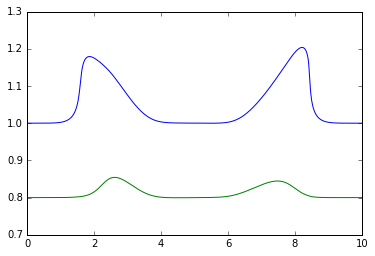

In [415]:
plt.plot(x,h[0,1:-1,1000],x,h[1,1:-1,1000])
plt.show()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f16881e31e0> (for post_execute):


ValueError: too many values to unpack (expected 2)

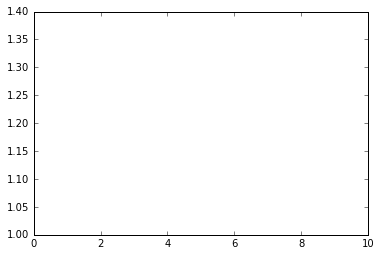

In [418]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(1.,1.4))
line = ax.plot([],[], lw=2)[0]
line2 = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(x, h[0,1:-1,i*10])
    line2.set_data() x, h[1,1:-1,i*10])

anim = animation.FuncAnimation(fig, animate, frames=130, interval=25)#, init_func=init)